Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook. [ref](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Import

We import all the necessary packages. We are going to work with `fastai 1.0.5x` which sits on top of `pytorch 1.x`, and opencv-python.

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.callbacks import SaveModelCallback
from functools import partial
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import re, os
import random
import fastai

In [3]:
fastai.__version__

'1.0.55'

# Preprocess

Let's find our raw images and manually labelled masks.

In [4]:
raw_dir = Path("raw")

raws = [raw_path for raw_path in raw_dir.ls() if ".tif" in raw_path.as_posix()]
labels = sorted([raw_path for raw_path in raws if "_label" in raw_path.name])
images = [Path(re.sub(r'_label', '_image', raw_path.as_posix())) for raw_path in labels]

In [5]:
for label,image in zip(labels,images):
    print(label, image)

raw/AIDOXNTDT_14_SO_10_Z0020_label.tif raw/AIDOXNTDT_14_SO_10_Z0020_image.tif
raw/AIDOXNTDT_14_SO_10_Z0268_label.tif raw/AIDOXNTDT_14_SO_10_Z0268_image.tif


Megan labelled 672\*448px sized images, but we need to train fastai's resnet34 model on 224*224px sized images so let's cut them up.

In [6]:
processed_dir = Path("processed")
os.makedirs(processed_dir, exist_ok=True)
# for f in processed_dir.ls(): os.remove(f)
l=224

In [7]:
from tqdm import tqdm
empty_tile = 0
populated_tile= 0

for image_path,label_path in tqdm(zip(images,labels)):
    image = cv.imread(image_path.as_posix(), cv.COLOR_BGR2GRAY)
    label = cv.imread(label_path.as_posix(), cv.COLOR_BGR2GRAY)

    if image.shape != label.shape:
        raise ValueError(image_path.as_posix() + label_path.as_posix())
    i_max = image.shape[0]//l
    j_max = image.shape[1]//l

# If the cells were labelled as 255, or something else mistakenly, instead of 1.
    label[label!=0]=1

    for i in range(i_max):
        for j in range(j_max):
            cropped_image = image[l*i:l*(i+1), l*j:l*(j+1)]
            cropped_label = label[l*i:l*(i+1), l*j:l*(j+1)]
            
            if (cropped_label!=0).any():
                populated_tile+=1
                cropped_image_path = processed_dir/(image_path.stem + "_i" + str(i) + "_j" + str(j) + image_path.suffix)
                cropped_label_path = processed_dir/(label_path.stem + "_i" + str(i) + "_j" + str(j) + label_path.suffix)
            else:
                empty_tile+=1
                cropped_image_path = processed_dir/(image_path.stem + "_i" + str(i) + "_j" + str(j) + "_empty" + image_path.suffix)
                cropped_label_path = processed_dir/(label_path.stem + "_i" + str(i) + "_j" + str(j) + "_empty" + label_path.suffix)
 
            cv.imwrite(cropped_image_path.as_posix(), cropped_image)
            cv.imwrite(cropped_label_path.as_posix(), cropped_label)

2it [00:00, 28.53it/s]


In [8]:
f"There are {populated_tile} tiles with cells in them, and {empty_tile} empty tiles."

'There are 12 tiles with cells in them, and 0 empty tiles.'

# fastAI

**NB:** From here onwards we will train the fastAI model. This process is very well documented in their [part 1](https://course.fast.ai/videos/?lesson=1) of their lecture series and I highly recommend you watch it.

## Databunch

fastai offers a well documented [image transformation library](https://docs.fast.ai/vision.transform.html) written from scratch in PyTorch.

In [9]:
transforms = get_transforms(
    do_flip = True,
    flip_vert = True,
    max_zoom = 1, #consider
    max_rotate = 0,
    max_lighting = None,
    max_warp = None,
    p_affine = 0.75,
    p_lighting = 0.75)

We use fastAI's [data block API](https://docs.fast.ai/data_block.html) to load our preprocessed data from above.

In [10]:
get_label_from_image = lambda path: re.sub(r'_image_', '_label_', path.as_posix())
codes = ["NOT-CELL", "CELL"]

bs = 9

src = (
    SegmentationItemList.from_folder(processed_dir)
    .filter_by_func(lambda fname:'image' in Path(fname).name)
    .split_by_rand_pct(valid_pct=0.25, seed=2)
    .label_from_func(get_label_from_image, classes=codes)
)
data = (
    src.transform(transforms, tfm_y=True)
    .databunch(bs=bs)
    .normalize(imagenet_stats)
)

In [11]:
data

ImageDataBunch;

Train: LabelList (9 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: processed;

Valid: LabelList (3 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: processed;

Test: None

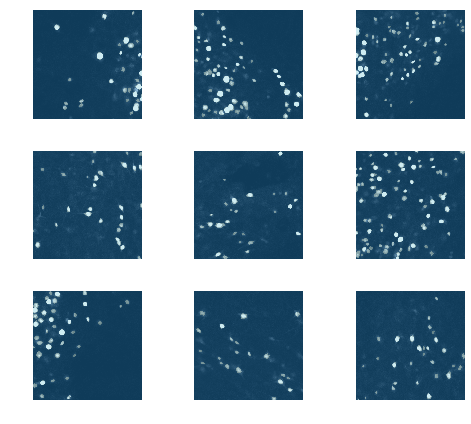

In [12]:
data.show_batch(rows=3, figsize=(7,6))

# Training

The `to_fp16()` method is used to reduce the size of the weights so that the exported file can be under [Github's strict filesize limit](https://help.github.com/en/github/managing-large-files/what-is-my-disk-quota#file-and-repository-size-limitations).

In [13]:
learn = unet_learner(
    data,
    models.resnet34,
    metrics=partial(dice, iou=True),
    model_dir='..').to_fp16()

find the learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-05
Min loss divided by 10: 1.32E-03


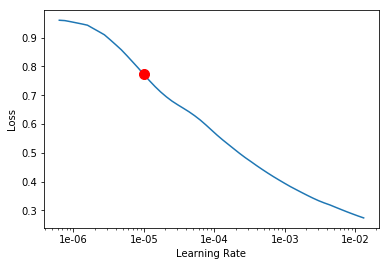

In [14]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [15]:
lr = 5e-04
learn.fit_one_cycle(cyc_len = 20,
                    callbacks =[SaveModelCallback(
                        learn,
                        every='improvement',
                        monitor = 'dice',
                        name='best-stage1')],
                    max_lr = lr)

epoch,train_loss,valid_loss,dice,time
0,0.964680,0.389701,0.003877,00:06
1,0.766354,0.149217,0.003638,00:01
2,0.612152,0.191296,0.000478,00:01
3,0.591920,0.098202,0.002879,00:01
4,0.519418,0.197897,0.034559,00:01
5,0.456250,0.060158,0.122222,00:01
6,0.396788,0.059031,0.119454,00:01
7,0.352906,0.033581,0.380673,00:01
8,0.316471,0.027317,0.461463,00:01
9,0.286802,0.027856,0.357910,00:01


Better model found at epoch 0 with dice value: 0.0038769233506172895.
Better model found at epoch 4 with dice value: 0.03455914929509163.
Better model found at epoch 5 with dice value: 0.12222222238779068.
Better model found at epoch 7 with dice value: 0.38067349791526794.
Better model found at epoch 8 with dice value: 0.46146342158317566.
Better model found at epoch 11 with dice value: 0.519569456577301.
Better model found at epoch 12 with dice value: 0.6110567450523376.
Better model found at epoch 13 with dice value: 0.6316046714782715.
Better model found at epoch 19 with dice value: 0.6350293755531311.


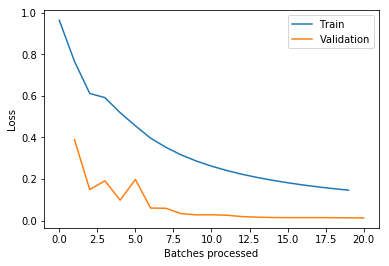

In [16]:
learn.recorder.plot_losses()

In [17]:
learn.load("best-stage1");

In [18]:
learn.unfreeze()

In [19]:
lrs = slice(lr/1000,lr/10)

In [20]:
learn.fit_one_cycle(cyc_len = 12,
                    max_lr = lrs,
                    pct_start = 0.8,
                    callbacks =[SaveModelCallback(
                        learn,
                        every='improvement',
                        monitor = 'dice',
                        name='best-stage2')])

epoch,train_loss,valid_loss,dice,time
0,0.028392,0.012151,0.650196,00:01
1,0.028316,0.011503,0.671883,00:01
2,0.028136,0.010405,0.704878,00:01
3,0.028074,0.009450,0.747110,00:01
4,0.028021,0.008974,0.765242,00:01
5,0.027956,0.008832,0.751085,00:01
6,0.027807,0.009424,0.726874,00:01
7,0.027665,0.009237,0.730676,00:01
8,0.027584,0.008172,0.766152,00:01
9,0.027414,0.007578,0.799137,00:01


Better model found at epoch 0 with dice value: 0.6501957178115845.
Better model found at epoch 1 with dice value: 0.6718826293945312.
Better model found at epoch 2 with dice value: 0.704878032207489.
Better model found at epoch 3 with dice value: 0.7471098303794861.
Better model found at epoch 4 with dice value: 0.7652423977851868.
Better model found at epoch 8 with dice value: 0.7661523818969727.
Better model found at epoch 9 with dice value: 0.7991371154785156.
Better model found at epoch 10 with dice value: 0.8082454204559326.
Better model found at epoch 11 with dice value: 0.8092042803764343.


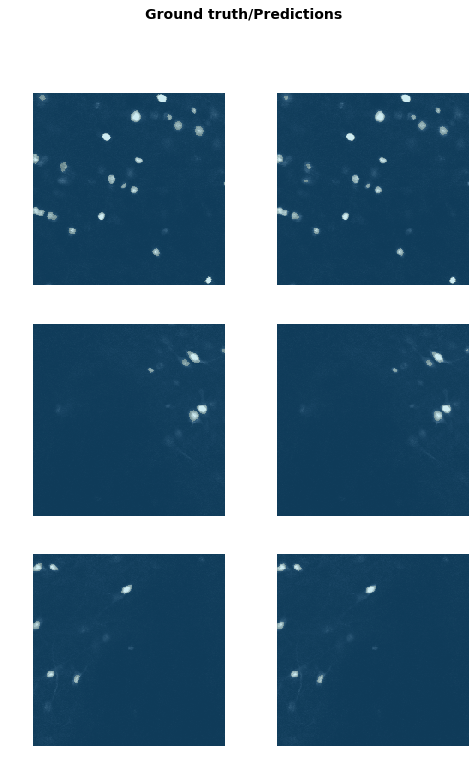

In [21]:
learn.show_results(rows=3)

This exported neural network is exactly that used in the test suite!

In [22]:
learn.export(file = "../training_example.pkl")